# Paths
- path that I will use on my notebook

- If plot of OCR doesn't work- please unnote this command.

In [1]:
%matplotlib inline


- Please change it to the final_project fir (the last one from zip extract) ..\final_project\final_project

In [2]:

path_final_project=r"C:\Users\ilaiga.Owner\Downloads\final_project"


Path to data

In [3]:
import os
path_dataset=os.path.join(path_final_project,'DataSet_scroll')
path_data_=os.path.join(path_dataset, 'images')
path_to_data_over_fit=os.path.join(path_data_, 'Over_fit')
path_to_data_train=os.path.join(path_data_, 'Train')
path_to_data_val=os.path.join(path_data_, 'Val')
path_to_data_test=os.path.join(path_data_,'Test')

path to labels

In [4]:
path_labels=os.path.join(path_dataset, 'labels')
labels_over_fit=os.path.join(path_labels, 'Over_fit')
labels_train=os.path.join(path_labels, 'Train')
labels_val=os.path.join(path_labels, 'Val')
labels_test=os.path.join(path_labels, 'Test')

- resize images for yolo

In [5]:

import os
from PIL import Image

def resize_image_and_annotations(image_path, annotation_path, new_size):
    # Open and resize the image
    image = Image.open(image_path)
    image_resized = image.resize(new_size, Image.BILINEAR)
    
    # Calculate scaling factors for bounding box coordinates
    width_ratio = new_size[0] / image.width
    height_ratio = new_size[1] / image.height
    
    # Update bounding box coordinates in the annotation file
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            annotations = f.readlines()
        
        updated_annotations = []
        for annotation in annotations:
            # Split each annotation line into parts
            parts = annotation.split()
            if len(parts) == 5:  # Each annotation line should have 5 parts: class x_center y_center width height
                # Update bounding box coordinates
                x_center = float(parts[1]) * width_ratio
                y_center = float(parts[2]) * height_ratio
                width = float(parts[3]) * width_ratio
                height = float(parts[4]) * height_ratio
                updated_annotation = f"{parts[0]} {x_center} {y_center} {width} {height}\n"
                updated_annotations.append(updated_annotation)
        
        # Save the updated annotation file
        with open(annotation_path, 'w') as f:
            f.writelines(updated_annotations)
    
    # Save the resized image
    image_resized.save(image_path)

def resize_images_in_path(image_dir, annotation_dir, new_size):
    # Iterate over each image in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Construct paths to image and annotation files
            image_path = os.path.join(image_dir, filename)
            annotation_path = os.path.join(annotation_dir, os.path.splitext(filename)[0] + '.txt')
            # Resize image and update annotations
            resize_image_and_annotations(image_path, annotation_path, new_size)

# Define the new size for resizing (320,320)
new_size = (320, 320)

# Resize images and update annotations for each path
resize_images_in_path(path_to_data_over_fit, labels_over_fit, new_size)
resize_images_in_path(path_to_data_train, labels_train, new_size)
resize_images_in_path(path_to_data_val, labels_val, new_size)

# Resize images for the test directory without annotations
resize_images_in_path(path_to_data_test, labels_test, new_size)



# Step 1- Yolo Bounding Box
- First I use in yolo v8 to put bounding box on the scrolls

In [6]:
#! pip install ultralytics

In [7]:
import torch
from ultralytics import YOLO
import yaml                 
import torch
from PIL import Image
import os
import cv2
import time

In [8]:
path_config = path_final_project


# Create dataset configuration
dataset_config = {
    'path': path_config,
    'train': path_to_data_train,
    'val': path_to_data_val,
    'test': path_to_data_test,
    'nc': 1,
    'names': ['scroll']
}


# Save dataset configuration to YAML file
dataset_yaml_path = os.path.join(path_config, 'dataset.yaml')
with open(dataset_yaml_path, 'w') as file:
    yaml.dump(dataset_config, file)

In [9]:
model = YOLO('yolov8n.yaml') 
model = YOLO('yolov8n.pt')              
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights
model.train(
    data=dataset_yaml_path,
    epochs=30,
    patience=100,
    batch=4,  
    imgsz=320 
)

Transferred 355/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.2.10 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2  Python-3.11.5 torch-2.3.0+cu118 CUDA:0 (NVIDIA RTX A5000, 24564MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:\Users\ilaiga.Owner\Downloads\final_project\dataset.yaml, epochs=30, time=None, patience=100, batch=4, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

c:\Users\ilaiga.Owner\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 


train: Scanning C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\labels\Train.cache... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<?, ?it/s]

train: WARNING  C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Train\M42035-1-C.jpg: 1 duplicate labels removed



val: Scanning C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\labels\Val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.619G      2.363      3.545      1.621        119        320: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         14        760      0.016     0.0737    0.00865    0.00433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.606G      2.111      3.301      1.409        195        320: 100%|██████████| 14/14 [00:01<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.05it/s]

                   all         14        760     0.0806      0.401     0.0958     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.493G      1.844       2.65      1.232        132        320: 100%|██████████| 14/14 [00:01<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.61it/s]


                   all         14        760      0.122      0.661       0.23      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.495G      1.834      2.103      1.208        119        320: 100%|██████████| 14/14 [00:01<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

                   all         14        760      0.142      0.712      0.335      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.493G      1.918      1.849      1.232         93        320: 100%|██████████| 14/14 [00:01<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.80it/s]

                   all         14        760       0.73      0.252      0.422      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.493G      2.055       1.75      1.295         80        320: 100%|██████████| 14/14 [00:01<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]

                   all         14        760      0.595      0.428      0.497      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.495G      2.054      1.689      1.223        193        320: 100%|██████████| 14/14 [00:01<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.65it/s]

                   all         14        760      0.546      0.523      0.498      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.495G      2.008      1.608       1.23        107        320: 100%|██████████| 14/14 [00:01<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]

                   all         14        760      0.554      0.446       0.44      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.495G      1.982      1.569      1.256        239        320: 100%|██████████| 14/14 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]

                   all         14        760      0.618      0.458      0.475      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.495G      1.916      1.464      1.217        258        320: 100%|██████████| 14/14 [00:01<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

                   all         14        760      0.689      0.627      0.659       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.495G      2.018      1.519      1.228        305        320: 100%|██████████| 14/14 [00:01<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.80it/s]

                   all         14        760       0.71      0.663      0.695      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.495G      1.883      1.445      1.202        211        320: 100%|██████████| 14/14 [00:01<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]

                   all         14        760      0.754      0.662      0.714       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.495G      1.927      1.408      1.221         97        320: 100%|██████████| 14/14 [00:01<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.64it/s]

                   all         14        760      0.759      0.658      0.698      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.495G      1.887      1.308      1.212        117        320: 100%|██████████| 14/14 [00:01<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.80it/s]

                   all         14        760      0.759      0.658      0.698      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.495G       1.89        1.3       1.18        135        320: 100%|██████████| 14/14 [00:01<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]

                   all         14        760      0.715      0.663      0.678      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.495G      1.808      1.239      1.153        173        320: 100%|██████████| 14/14 [00:01<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         14        760      0.679      0.647      0.632      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.497G      1.837      1.259      1.183        190        320: 100%|██████████| 14/14 [00:01<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.80it/s]

                   all         14        760      0.706      0.637      0.639      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.495G      1.916      1.277      1.212        141        320: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.03it/s]

                   all         14        760      0.746      0.649      0.667      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.495G      1.815      1.247      1.206         84        320: 100%|██████████| 14/14 [00:01<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         14        760      0.756      0.668      0.692      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.495G      1.808      1.264      1.178         53        320: 100%|██████████| 14/14 [00:01<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]

                   all         14        760      0.771      0.686      0.723      0.377


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.497G      1.731      1.203      1.192        170        320: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.63it/s]

                   all         14        760      0.764      0.705      0.736       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.493G      1.746      1.154      1.175         53        320: 100%|██████████| 14/14 [00:01<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]

                   all         14        760      0.764      0.705      0.736       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.495G       1.68      1.171      1.188         83        320: 100%|██████████| 14/14 [00:01<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]

                   all         14        760      0.765      0.712      0.748      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.495G      1.679      1.171      1.184         85        320: 100%|██████████| 14/14 [00:01<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.18it/s]

                   all         14        760      0.772        0.7      0.746      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.497G      1.663       1.14      1.158         81        320: 100%|██████████| 14/14 [00:01<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         14        760      0.782      0.703      0.753      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.499G      1.658      1.112       1.16        109        320: 100%|██████████| 14/14 [00:01<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.78it/s]

                   all         14        760      0.778      0.714      0.761      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.499G      1.646      1.162      1.164        127        320: 100%|██████████| 14/14 [00:01<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         14        760      0.779      0.723      0.772      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.495G       1.71      1.173      1.152        183        320: 100%|██████████| 14/14 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.09it/s]

                   all         14        760      0.801       0.72      0.777      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.493G      1.662      1.136       1.17         89        320: 100%|██████████| 14/14 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]

                   all         14        760      0.811      0.717       0.78      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.493G      1.609      1.112      1.156         76        320: 100%|██████████| 14/14 [00:01<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.74it/s]

                   all         14        760      0.811      0.717       0.78      0.374



30 epochs completed in 0.023 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.11.5 torch-2.3.0+cu118 CUDA:0 (NVIDIA RTX A5000, 24564MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


                   all         14        760      0.808      0.716      0.778      0.373
Speed: 0.0ms preprocess, 3.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002051E932710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

# Save model and predict

In [10]:
import glob

model_save_dir = os.path.join(path_dataset, 'saved_models')  

# Create the directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, 'my_model.pt')  
model.save(model_save_path)

print("Model saved successfully at:", model_save_path)


Model saved successfully at: C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\saved_models\my_model.pt


# Show the results of YOLO
- In runs directory I will got the information from train/val/test

- Show results

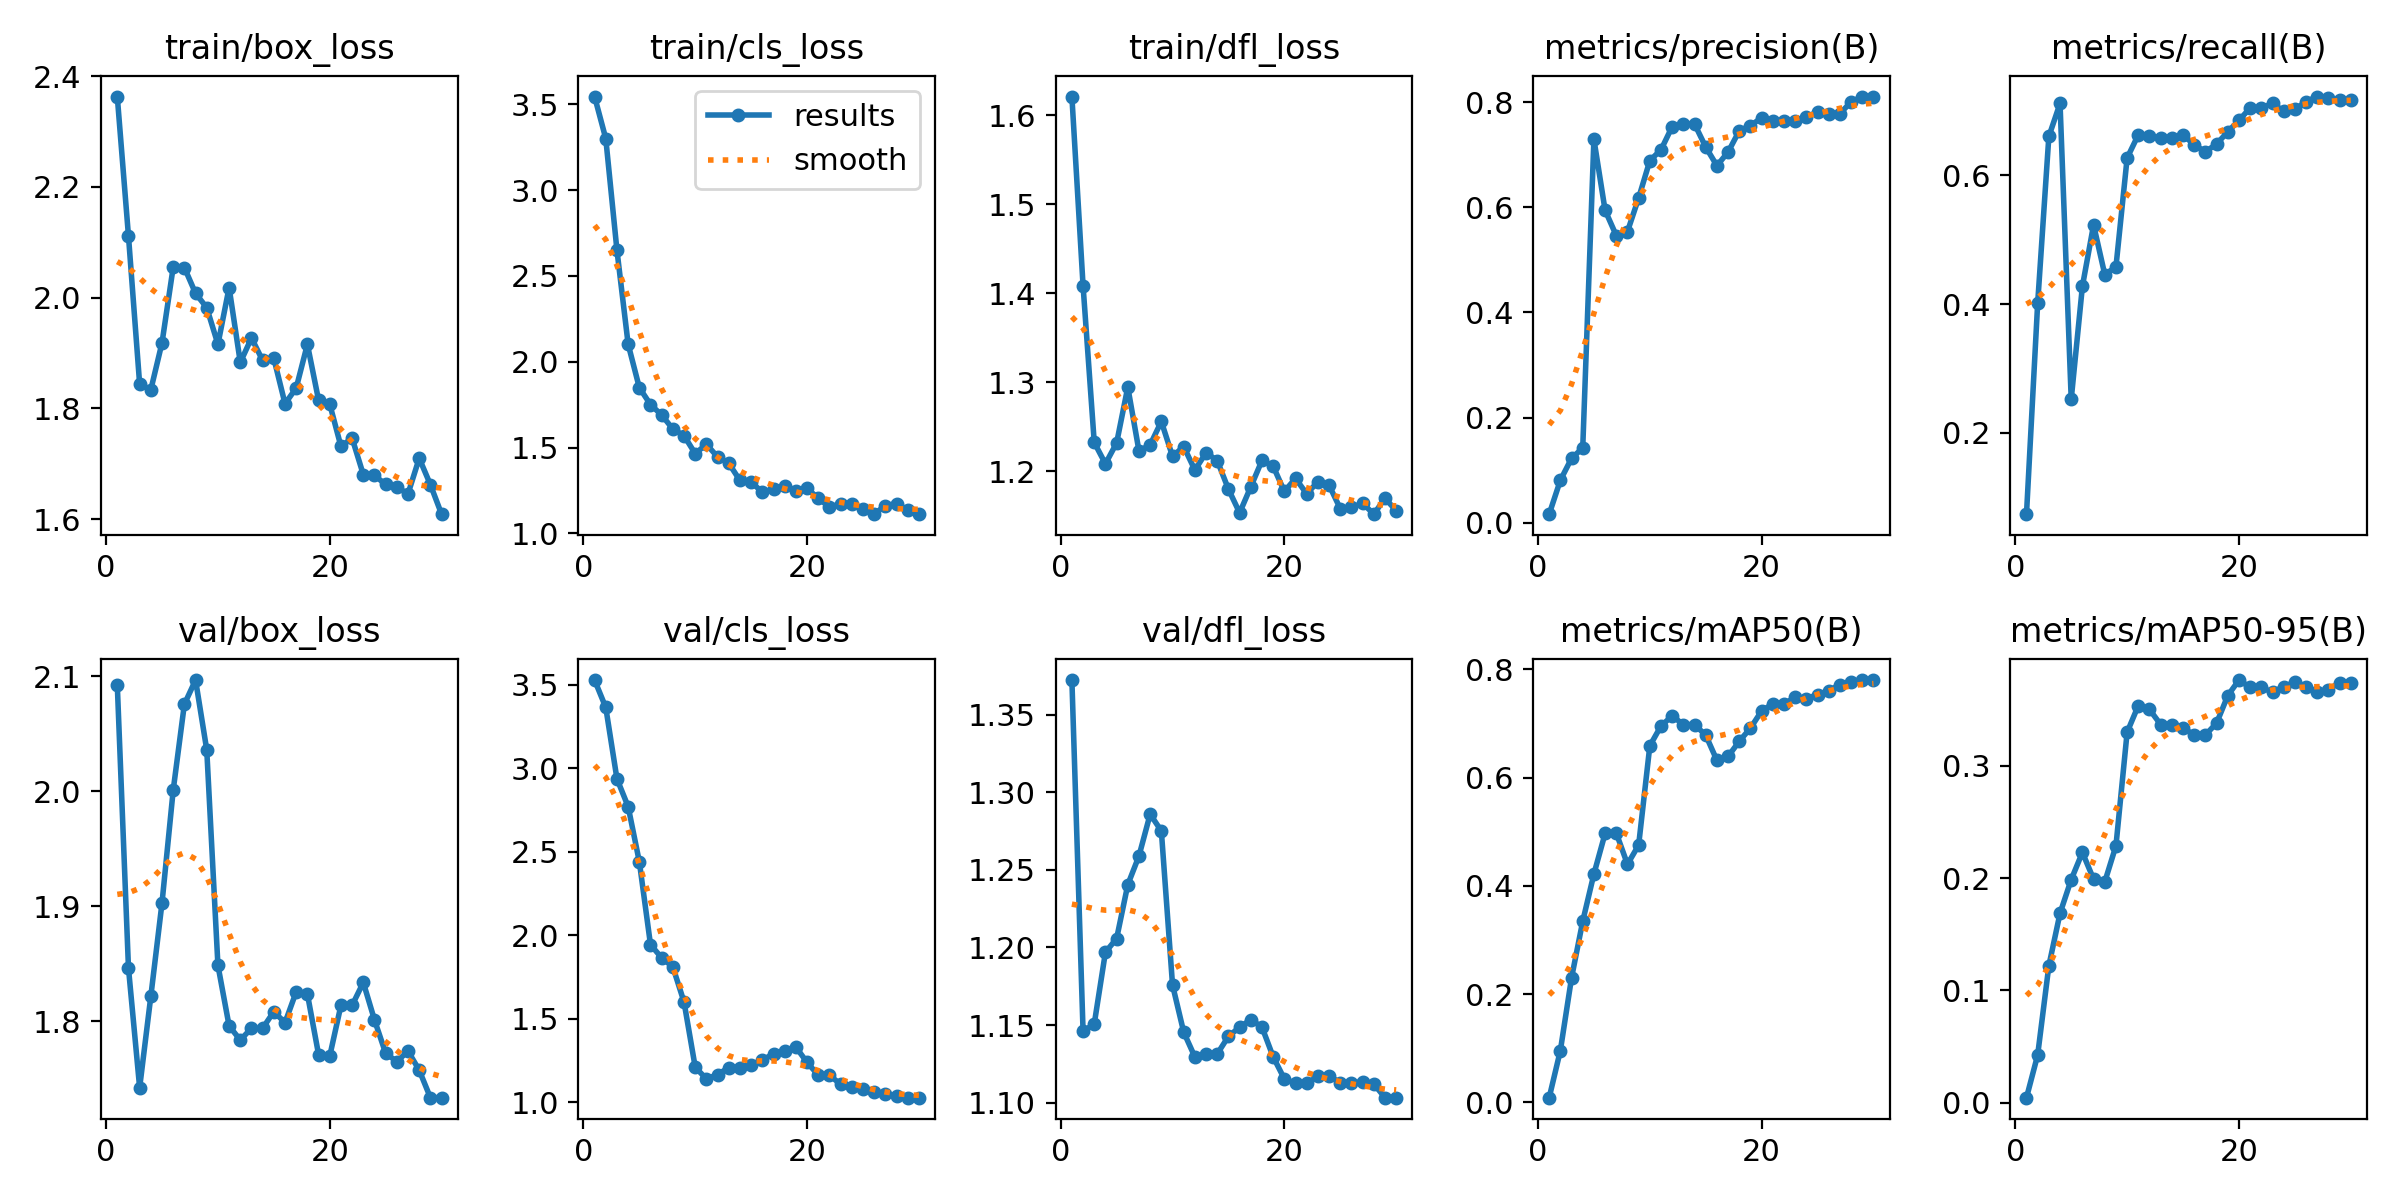

In [11]:
from PIL import Image
from IPython.display import display
import os

# Construct the path to the image
path_plot = os.path.join(path_final_project, 'runs', 'detect', 'train')  # Update the filename if different
path_results=os.path.join(path_plot, 'results.png')
# Open the image
img = Image.open(path_results)

# Display the image 
display(img)
      

- show confusion matrix normalized

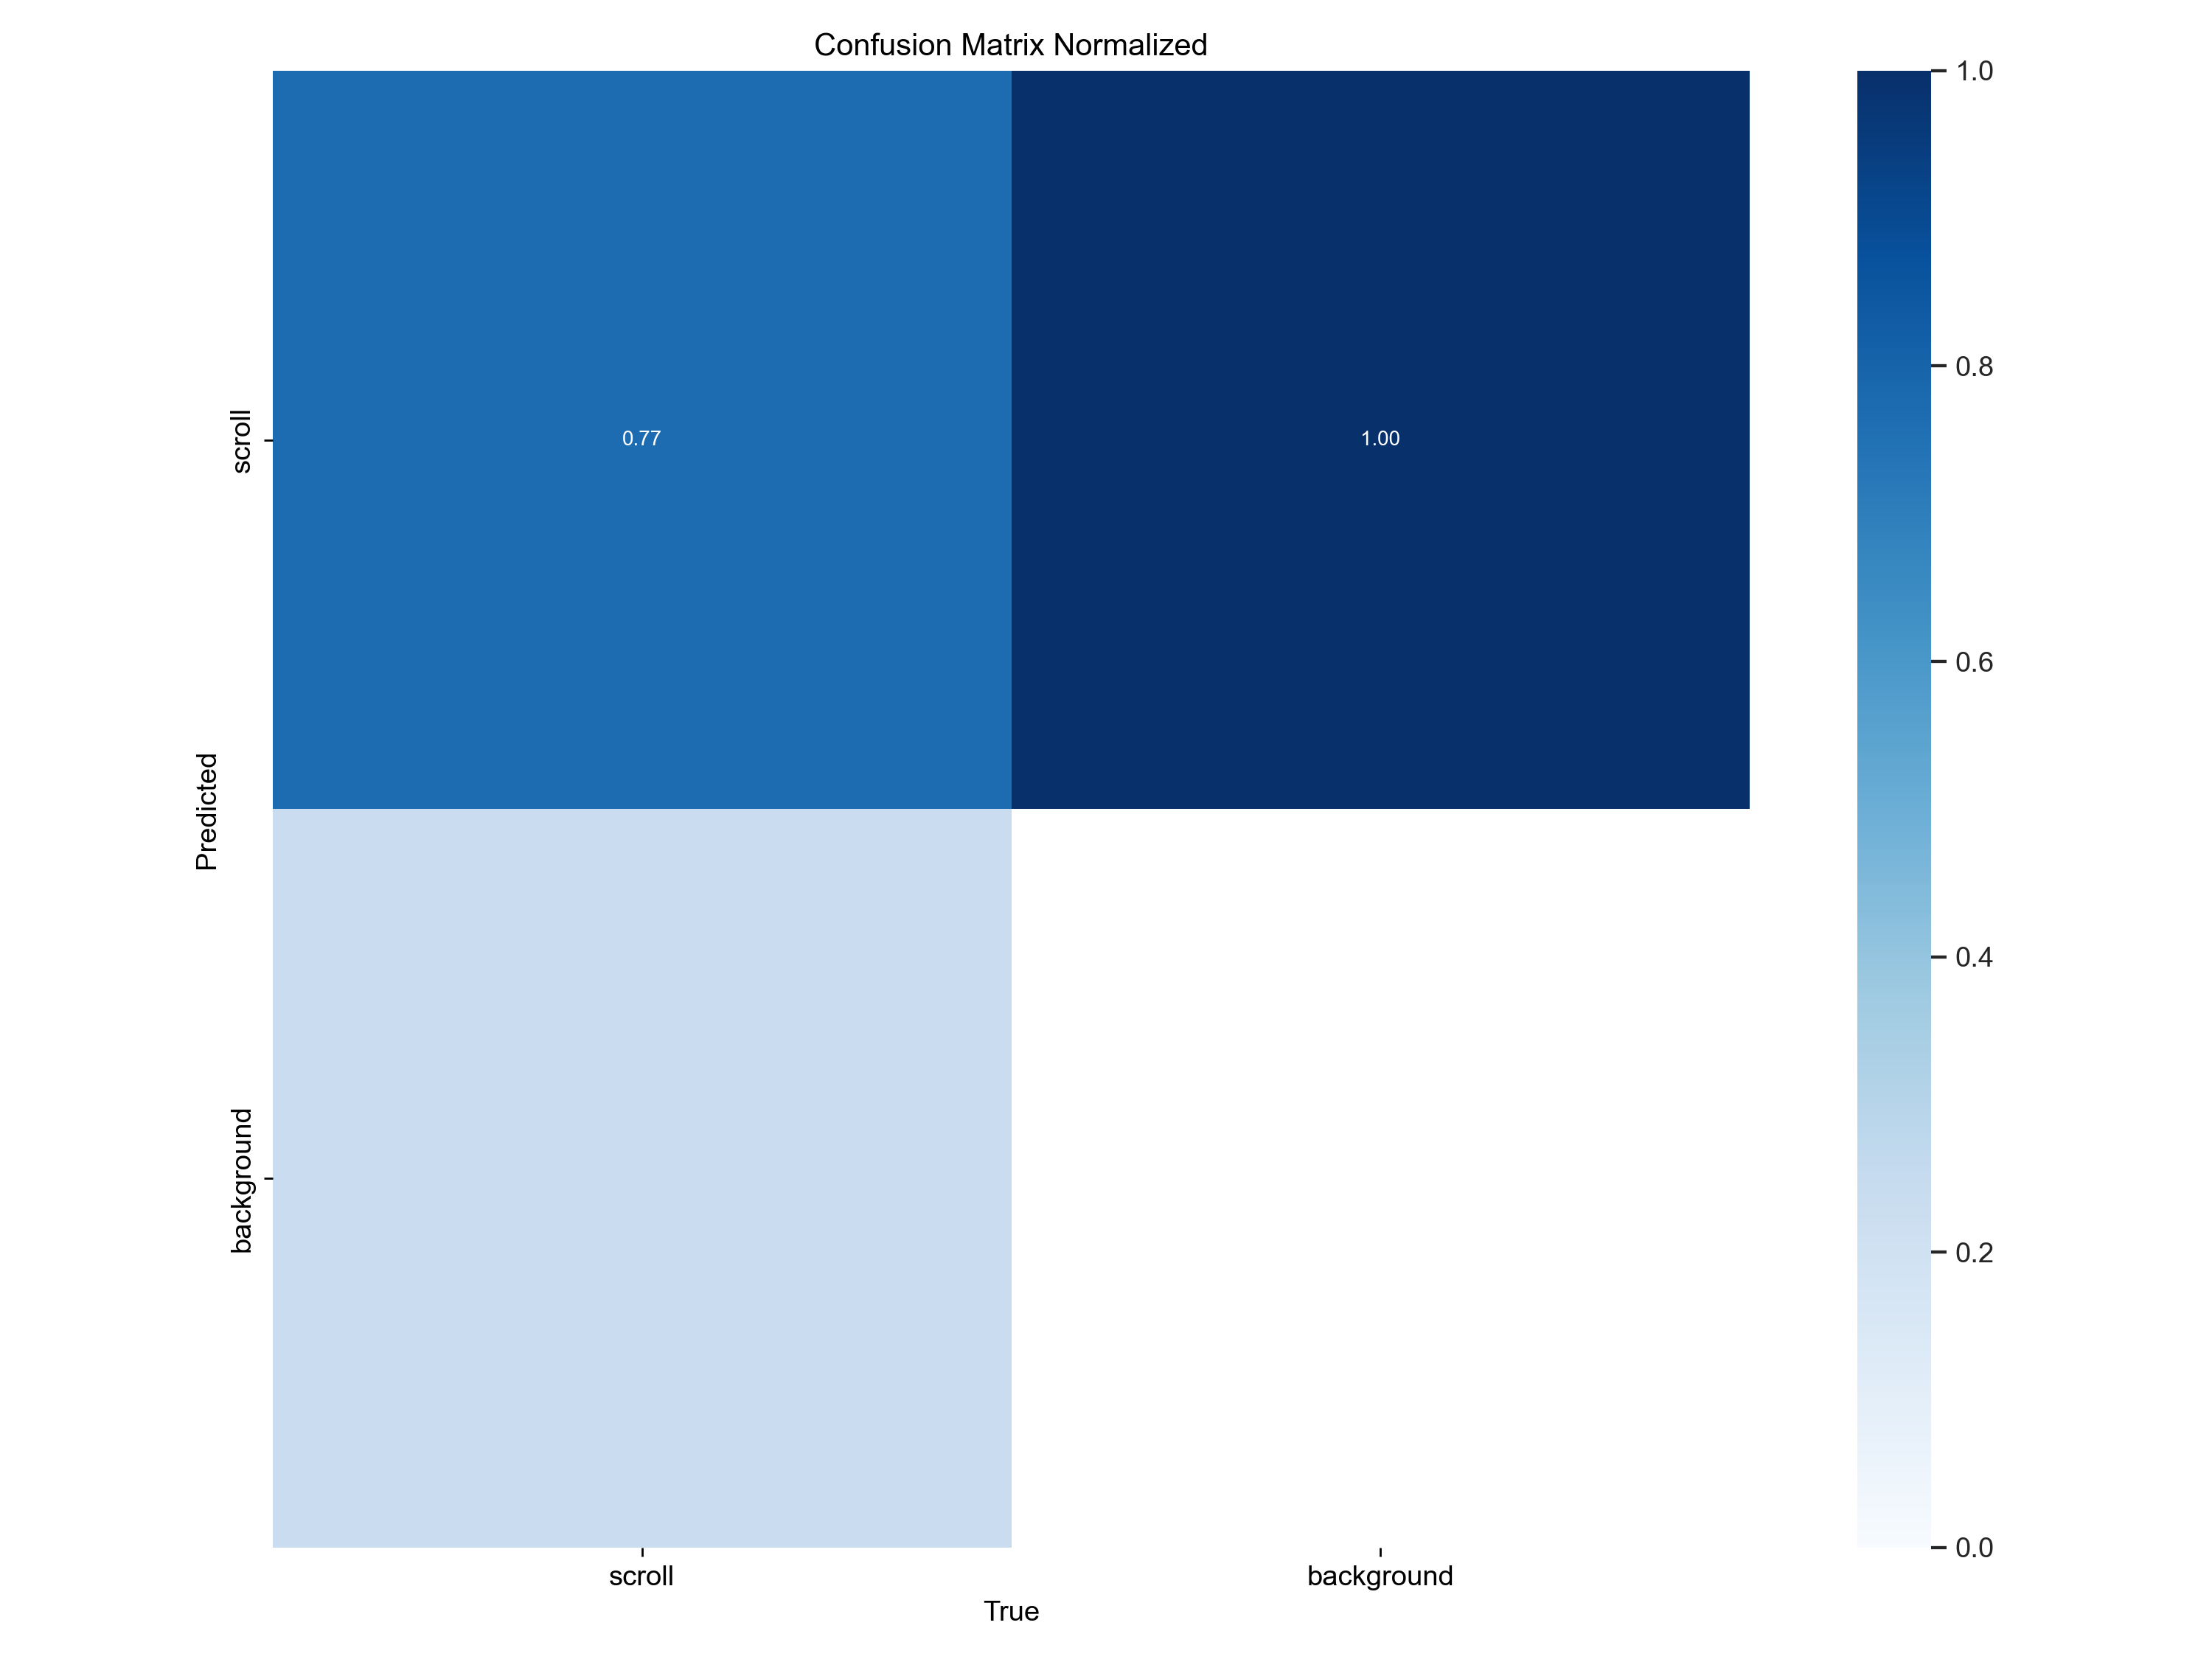

In [12]:
path_results=os.path.join(path_plot, 'confusion_matrix_normalized.png')
# Open the image
img = Image.open(path_results)

# Display the image 
display(img)

- show more result

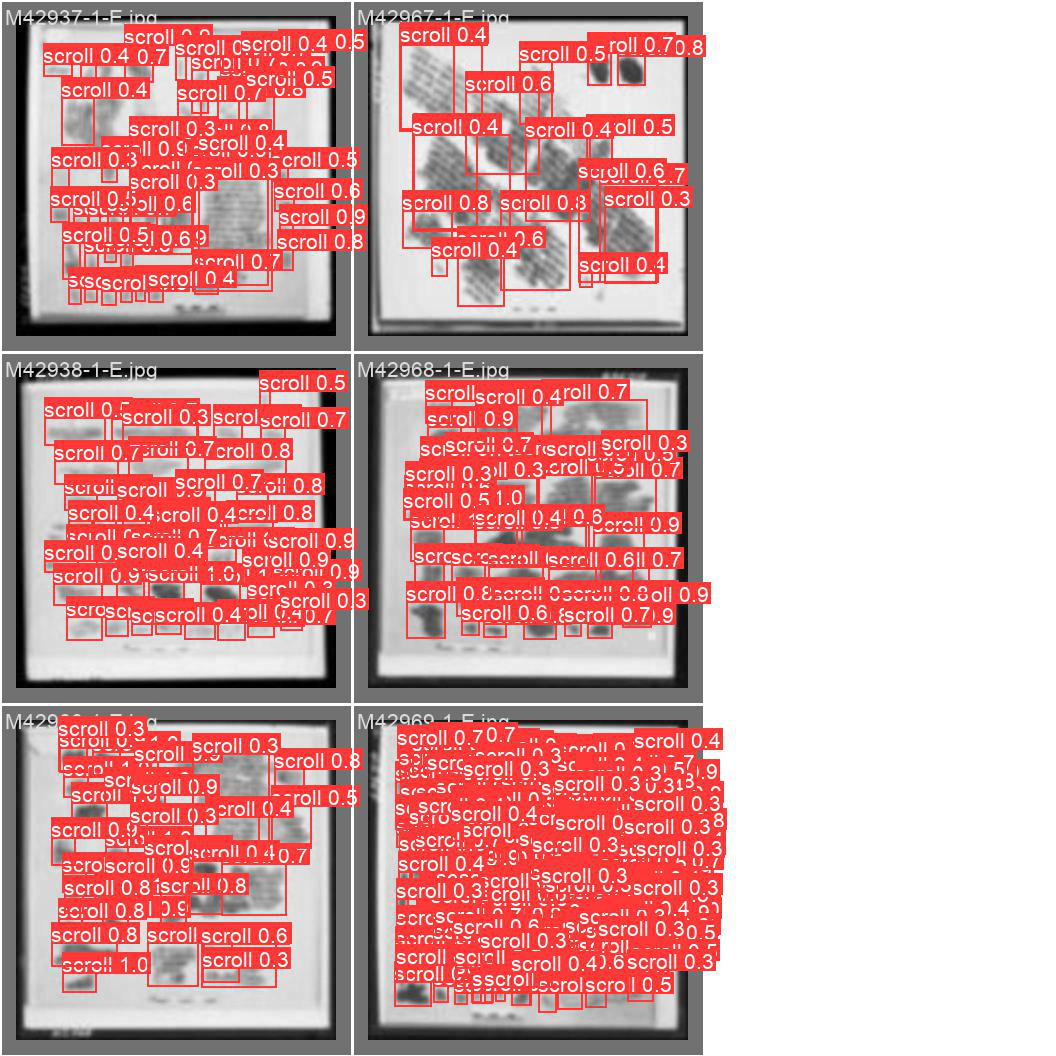

In [13]:
path_plot = os.path.join(path_final_project, 'runs', 'detect', 'train')  # Update the filename if different
path_results=os.path.join(path_plot, 'val_batch1_pred.jpg')
# Open the image
img = Image.open(path_results)

# Display the image 
display(img)

# Validation for YOLO

In [14]:
model_pretend_path = os.path.join(path_final_project, 'runs', 'detect', 'train', 'weights', 'best.pt')

# Load the pre-trained weights into the model
model_w=YOLO(model_pretend_path)


results_val = model_w.val(
    data=dataset_yaml_path,
    epochs=30,
    patience=100,
    batch=4,  
    imgsz=320
)


Ultralytics YOLOv8.2.2  Python-3.11.5 torch-2.3.0+cu118 CUDA:0 (NVIDIA RTX A5000, 24564MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\labels\Val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


                   all         14        760      0.803      0.724      0.782      0.374
Speed: 6.4ms preprocess, 40.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\detect\val


- show graphs
- PR curve
- F1_curve

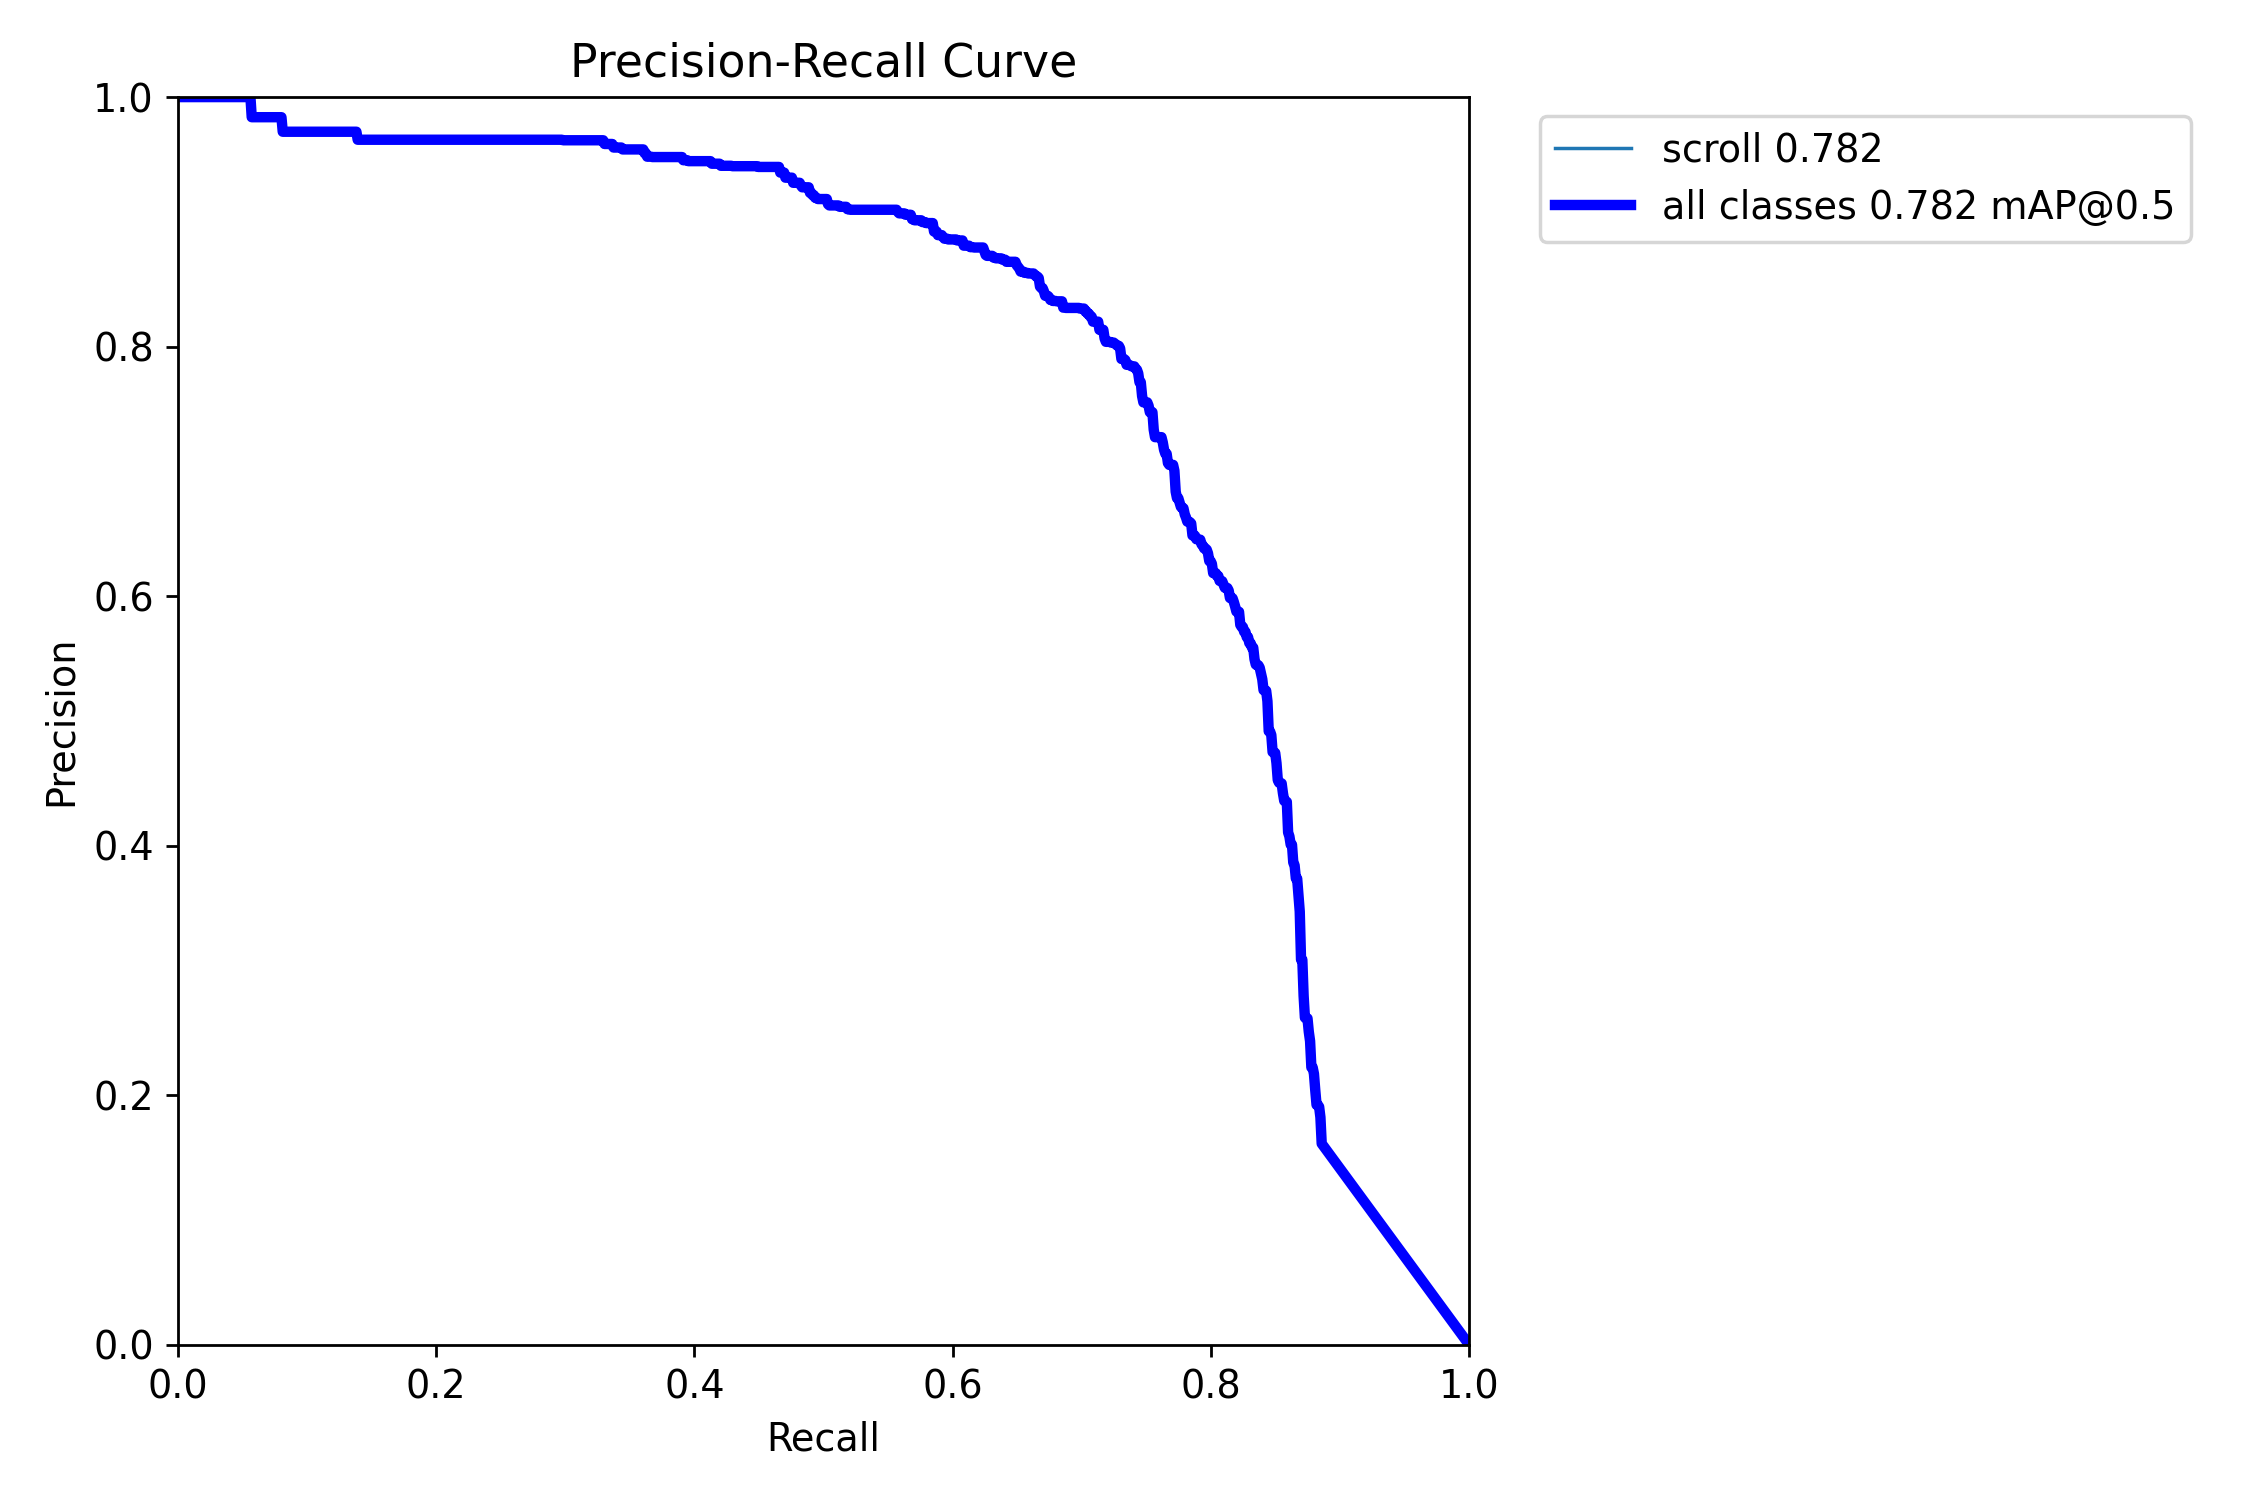

In [15]:
path_plot_val= os.path.join(path_final_project, 'runs', 'detect', 'val')
path_res= os.path.join(path_plot_val,'PR_curve.png')
img = Image.open(path_res)

# Display the image 
display(img)

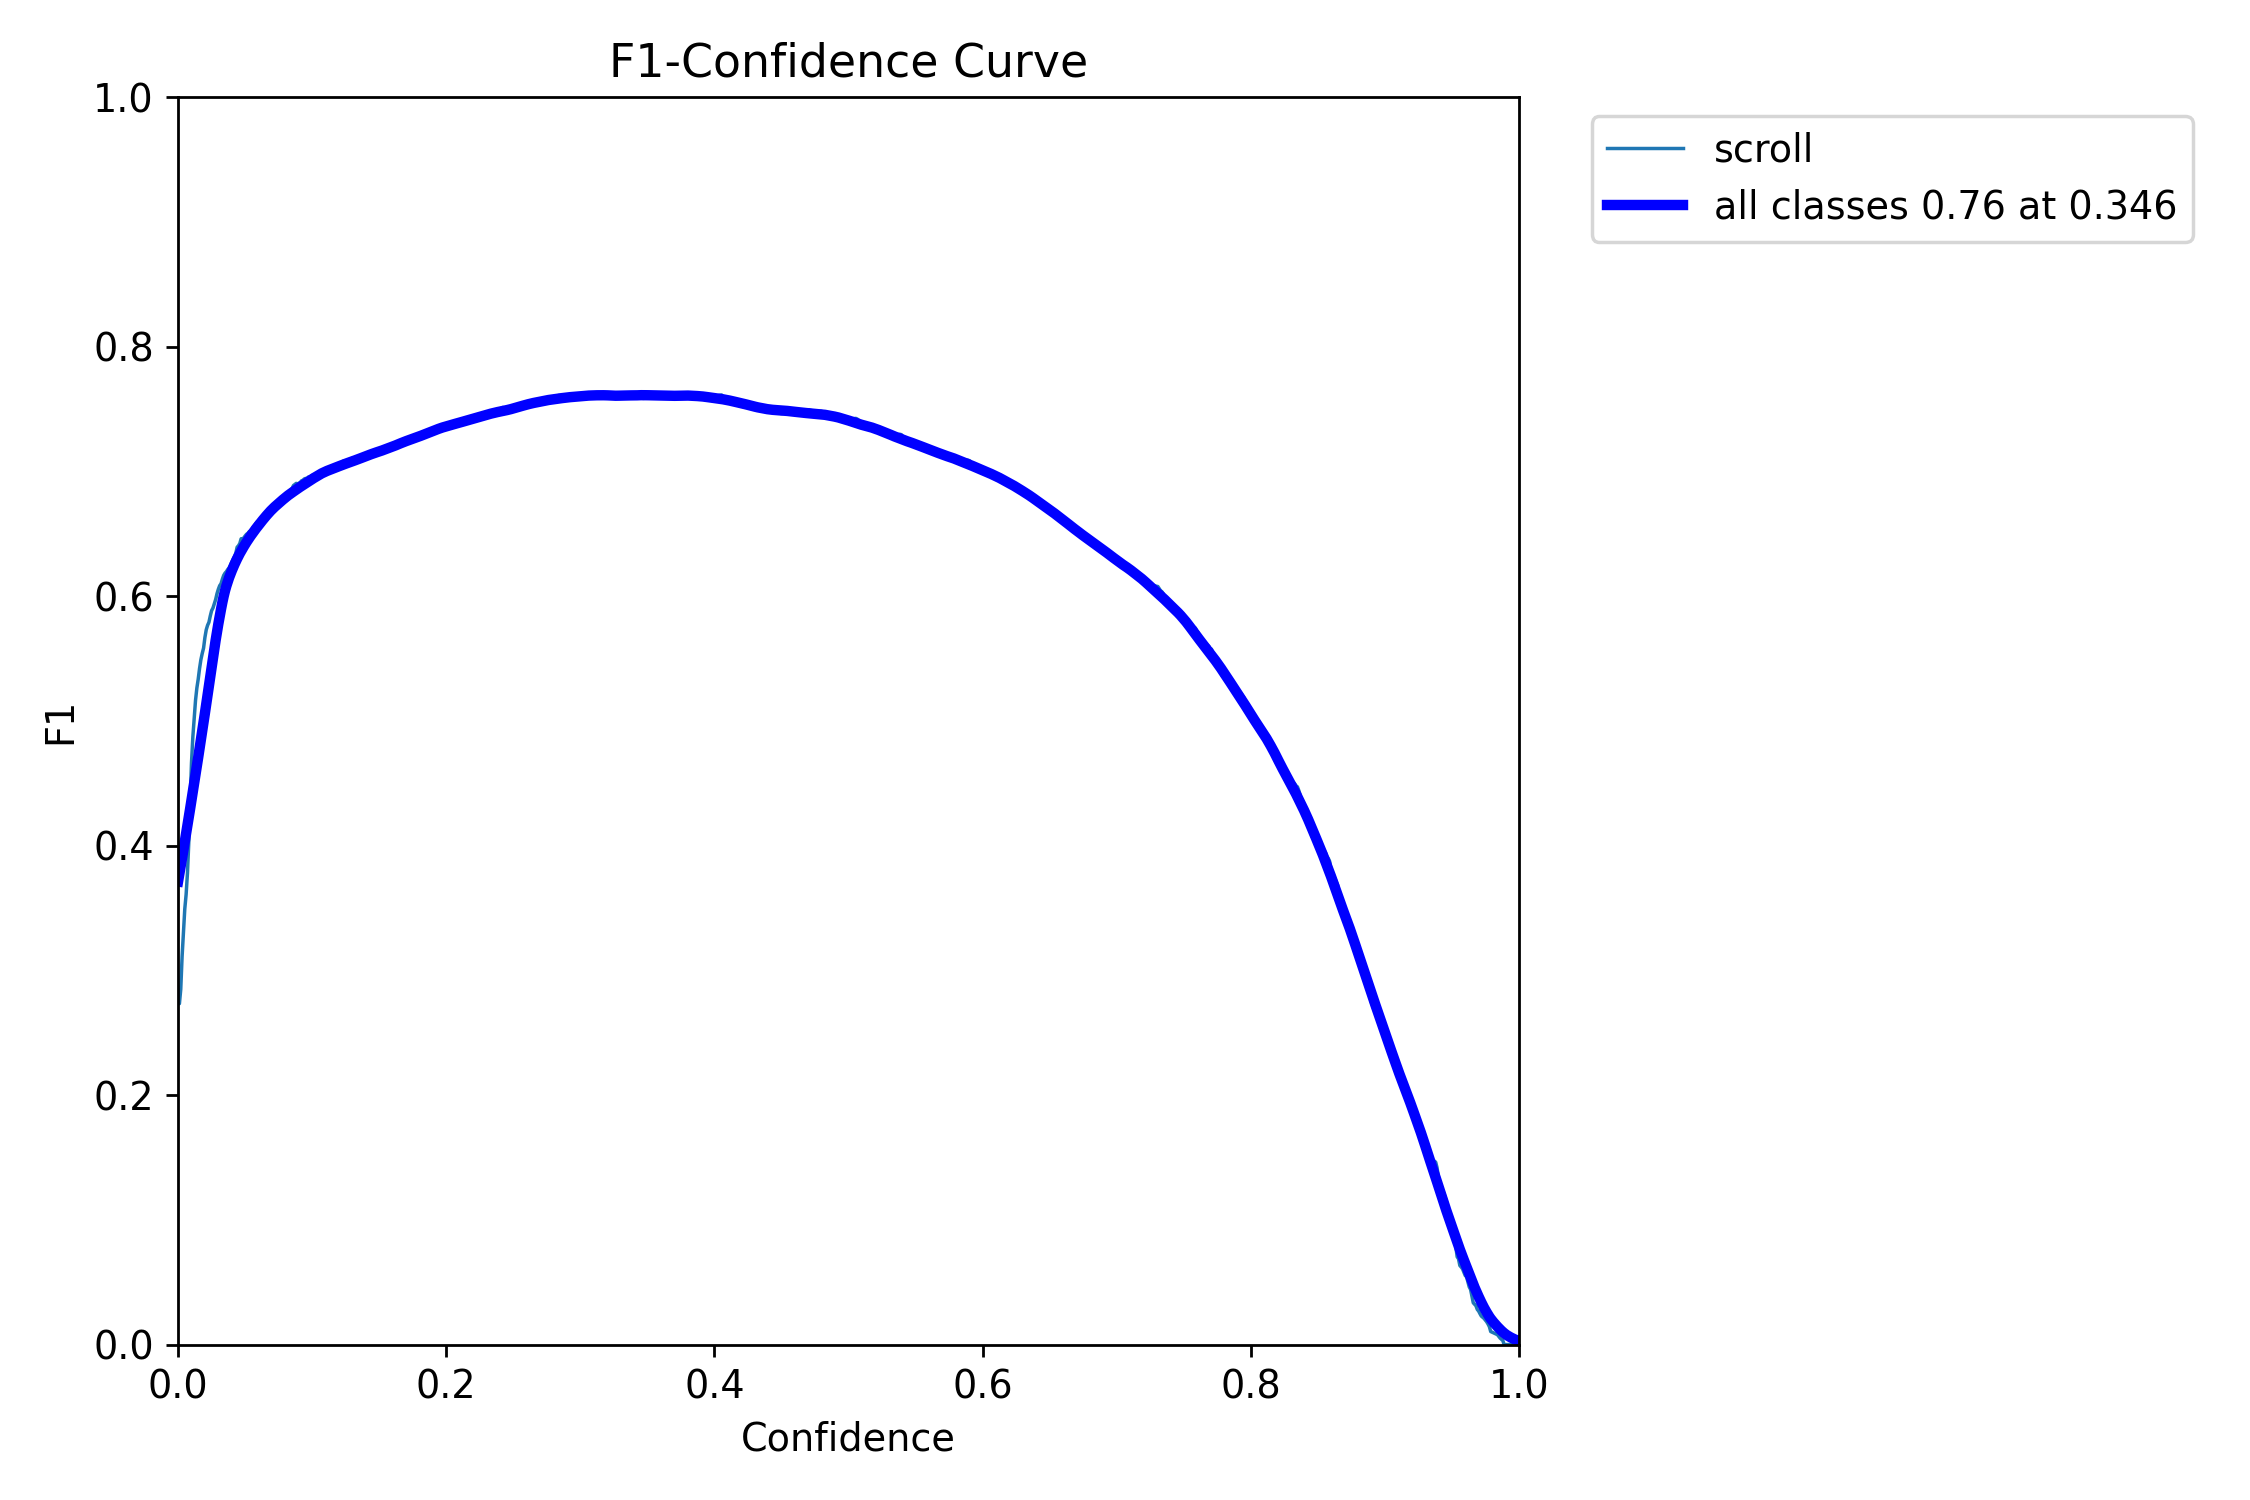

In [16]:
path_res= os.path.join(path_plot_val,'F1_curve.png')
img = Image.open(path_res)

# Display the image 
display(img)

- show val batch

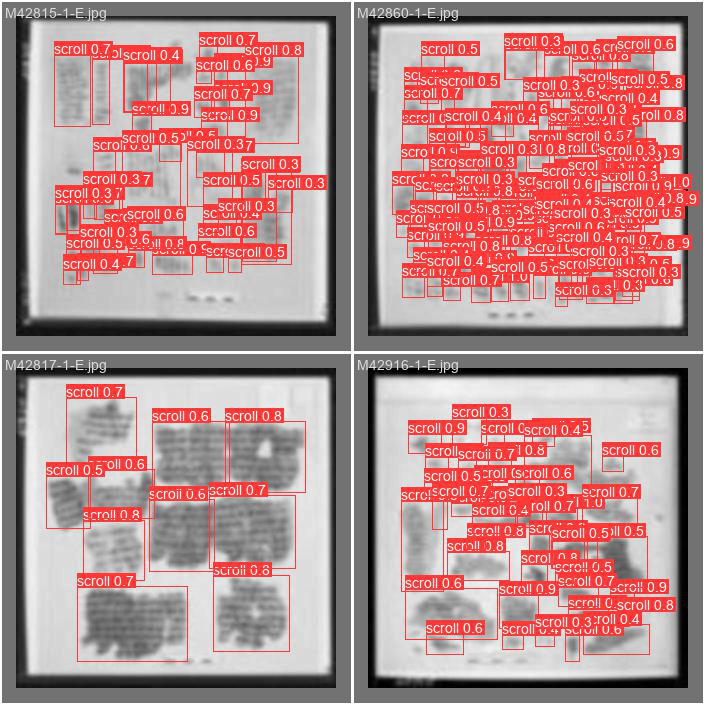

In [17]:
path_res= os.path.join(path_plot_val,'val_batch1_pred.jpg')
img = Image.open(path_res)

# Display the image 
display(img)



# Test

In [18]:
import matplotlib.pyplot as plt

# Load the pre-trained weights into the model
model_w = YOLO(model_pretend_path)

# Predict using the model
results_test = model_w.predict(path_to_data_test, save=True)

for img_path in glob.glob(f'/runs/detect/predict/*.jpg'):
    display(Image(filename=img_path, height=600))
    print("\n")


image 1/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M42970-1-E.jpg: 320x320 68 scrolls, 15.0ms
image 2/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M42974-3-(1)C.jpg: 320x320 37 scrolls, 14.6ms
image 3/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M43003-1-E.jpg: 320x320 45 scrolls, 15.6ms
image 4/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M43174-1-E.jpg: 320x320 174 scrolls, 15.6ms
image 5/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M43194-1-E.jpg: 320x320 23 scrolls, 0.0ms
image 6/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M43195-1-E.jpg: 320x320 31 scrolls, 15.0ms
image 7/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M43362-1-E.jpg: 320x320 9 scrolls, 15.0ms
image 8/28 C:\Users\ilaiga.Owner\Downloads\final_project\DataSet_scroll\images\Test\M43448-1-E.jpg: 320x320 

- show test results

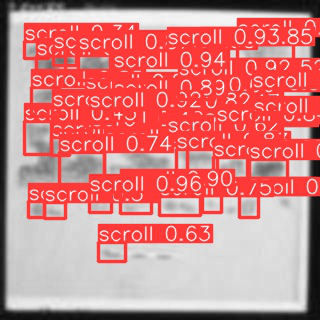

In [19]:
path_plot_test= os.path.join(path_final_project, 'runs', 'detect', 'predict')

path_res= os.path.join(path_plot_test,'M43003-1-E.jpg')
img = Image.open(path_res)

# Display the image 
display(img)

# Step 2- Build test bounding box file
- after create bounding box on the predict, I want to write the sizes of bounding box in file.txt that will help to isolate each scroll 

In [20]:
import os
import numpy as np

# Assuming 'results_test' contains results from a YOLO model prediction
for i, result in enumerate(results_test):
    # Ensure data is on CPU and converted to numpy arrays for processing
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes in [x1, y1, x2, y2] format
    classes = result.boxes.cls.cpu().numpy()  # Class IDs

    # Extract the original image filename without extension
    image_file_name = os.path.basename(result.path)
    image_base_name = os.path.splitext(image_file_name)[0]

    # Define path for new label file in the labels_test directory
    label_path = os.path.join(labels_test, f"{image_base_name}.txt")
    
    # Write each detection to the label file
    with open(label_path, 'w') as f:
        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = box
            # Calculate normalized center coordinates, width, and height
            x_center = ((x1 + x2) / 2) / result.orig_shape[1]
            y_center = ((y1 + y2) / 2) / result.orig_shape[0]
            width = (x2 - x1) / result.orig_shape[1]
            height = (y2 - y1) / result.orig_shape[0]
            
            # Write formatted data to file (without confidence score)
            f.write(f"{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [21]:
# ! pip uninstall opencv-python

# ! pip install opencv-contrib-python --user

# Isolate for check in high res automaticaliiy
- Now will extract each scroll with high resultion network

In [22]:
import os
import numpy as np
from PIL import Image

In [23]:
import cv2
#print(dir(cv2.dnn_superres))

In [24]:
path_high_res= os.path.join(path_final_project,'DataSet_scroll_high_res','Data_','images')
path_train_high_res= os.path.join(path_high_res,'Train')
path_val_high_res= os.path.join(path_high_res,'Val')
path_test_high_res= os.path.join(path_high_res,'Test')
path_over_fit_high_res= os.path.join(path_high_res,'Over_fit')

In [25]:
# labels from image
def parse_label_file(label_path, image_size):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x1 = int((x_center - width / 2) * image_size[0])
            y1 = int((y_center - height / 2) * image_size[1])
            x2 = int((x_center + width / 2) * image_size[0])
            y2 = int((y_center + height / 2) * image_size[1])
            boxes.append((x1, y1, x2, y2))
    return boxes

#method that put super resultion to extract scrolls in high resolusion
def apply_super_resolution(image, model_path):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel('fsrcnn', 4)  

    if len(image.shape) == 3 and image.shape[2] == 3:
        # If image is already in BGR format, use directly
        bgr_img = image
    else:
        # If grayscale, convert to BGR
        bgr_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    enhanced_img = sr.upsample(bgr_img)

    return enhanced_img

def process_dataset(image_dir, label_dir, output_dir, model_path):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(image_dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.rsplit('.', 1)[0] + '.txt')
        output_path = os.path.join(output_dir, filename)

        if os.path.exists(label_path):
            image = Image.open(image_path)
            image_size = image.size
            boxes = parse_label_file(label_path, image_size)

            for i, (x1, y1, x2, y2) in enumerate(boxes):
                crop_img = image.crop((x1, y1, x2, y2))
                crop_img_array = np.array(crop_img, dtype=np.uint8)
                enhanced_img = apply_super_resolution(crop_img_array, model_path)

                enhanced_filename = f"{os.path.splitext(filename)[0]}_scroll_{i}.png"
                cv2.imwrite(os.path.join(output_dir, enhanced_filename), enhanced_img)
        else:
            print(f"Label file for {filename} not found.")

In [26]:
# path for compare each scrolls later- divide to train and test
path_train_compare = os.path.join(os.getcwd(), 'For_compare', 'Data', 'Train')
path_test_compare = os.path.join(os.getcwd(), 'For_compare', 'Data', 'Test')

datasets = {
    'train': (path_train_high_res, labels_train, path_train_compare),
    'val': (path_val_high_res, labels_val, path_train_compare),
    'test': (path_test_high_res, labels_test, path_test_compare),
}

model_path = os.path.join(os.getcwd(), 'FSRCNN_x4.pb')  

# Process each dataset
for dataset_name, (image_dir, label_dir, output_dir) in datasets.items():
    print(f"Processing {dataset_name} dataset...")
    process_dataset(image_dir, label_dir, output_dir, model_path)

Processing train dataset...
Processing val dataset...
Processing test dataset...


# Images for compare

- first I resize all the images in a new directory that called "resize_photo" to 512*512

In [27]:
import os
from PIL import Image, ImageEnhance

def resize_and_set_dpi(image_path, target_size=(1024, 1024), dpi=(300, 300)):
    with Image.open(image_path) as img:
        resized_img = img.resize(target_size, Image.Resampling.LANCZOS)
        resized_img.info['dpi'] = dpi
        return resized_img

def increase_contrast(img, factor=1.5):
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(factor)
    return img

def resize_and_save_images(source_dir, dest_dir, target_size=(512, 512), contrast_factor=1.5, dpi=(300, 300)):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for filename in os.listdir(source_dir):
        if filename.lower().endswith((".jpg", ".png")):  
            file_path = os.path.join(source_dir, filename)
            try:
                # Resize, set DPI, and enhance image contrast
                resized_img = resize_and_set_dpi(file_path, target_size, dpi)
                enhanced_img = increase_contrast(resized_img, contrast_factor)
                
                # Save the enhanced image with DPI metadata
                enhanced_img.save(os.path.join(dest_dir, filename), dpi=dpi)
            except Exception as e:
                print(f"Failed to process {filename}: {e}")




In [28]:
path_train_compare = os.path.join(os.getcwd(), 'For_compare', 'Data', 'Train')
path_test_compare = os.path.join(os.getcwd(), 'For_compare', 'Data', 'Test')

In [29]:
path_resize_dir= os.path.join(path_final_project, 'resize_photo')
path_resize_train=os.path.join(path_resize_dir, 'Train')
path_resize_test=os.path.join(path_resize_dir, 'Test')

# Process images
resize_and_save_images(path_train_compare, path_resize_train)
resize_and_save_images(path_test_compare, path_resize_test)


# Step 3- OCR implement
- Now I will use in OCR to extract text and convert to digital
- after that I will compare each text

In [30]:
# ! pip install pytesseract
# ! pip install sentence-transformers


with dic

- use in dic to save the ocr results and move each pairs

In [31]:
import os
import itertools
import time
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
import pytesseract
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


def preprocess_image(image):
    # Convert image to grayscale
    image = image.convert('L')
    image = ImageOps.autocontrast(image)
    return image

def extract_text(image_path, save_processed_images=False):
    start_time = time.time()  # Start timing
    with Image.open(image_path) as img:
        # Preprocess the image
        preprocessed_img = preprocess_image(img)
        # Define Tesseract config
        config = '--oem 1 --psm 6'  # single uniform block of text
        if save_processed_images:
            config += ' tessedit_write_images=true'

        # Perform OCR with Tesseract using the updated config
        text = pytesseract.image_to_string(preprocessed_img, lang='heb_rashi', config=config) # lang='heb'
    processing_time = time.time() - start_time  # Calculate processing time
    #print(f"Extracted from {image_path}: {text[:100]} | Processing Time: {processing_time:.2f} seconds")
    return text, processing_time



# the text will be in vector
def text_to_vector(text, model):
    return model.encode([text])

# compare texts
def compare_texts(text1, text2, model):
    vec1 = text_to_vector(text1, model)
    vec2 = text_to_vector(text2, model)
    if vec1.ndim == 1:
        vec1 = vec1.reshape(1, -1)
    if vec2.ndim == 1:
        vec2 = vec2.reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

#this method will find a similar images by them text
def find_similar_images(directory, model):
    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    ocr_results = {}
    processing_times = []
    for file in files:
        text, time_taken = extract_text(os.path.join(directory, file), True)
        ocr_results[file] = text
        processing_times.append(time_taken)
        print(f"Processed {file}: Time taken = {time_taken}s, Text Length = {len(text)}")
    
    pairs = itertools.combinations(ocr_results.items(), 2)
    similar_images = []
    for (file1, text1), (file2, text2) in pairs:
        score = compare_texts(text1, text2, model)
        if score > 0.9:
            similar_images.append((file1, file2, score))
            print(f"Found similar: {file1}, {file2} with score {score}")
    
    return similar_images, processing_times

def save_similar_images_to_file(similar_images, file_path):
    with open(file_path, 'w') as file:
        for item in similar_images:
            if isinstance(item, tuple) and len(item) == 3:
                img1, img2, score = item
                file.write(f"{img1}, {img2}, Similarity Score: {score}\n")
            else:
                print(f"Error: Expected a tuple with 3 elements, received: {item}")



def plot_processing_and_similarity(processing_times, similar_images):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # Create a figure with two subplots vertically

    # Plot for processing times
    ax1.hist(processing_times, bins=20, color='blue', alpha=0.7)
    ax1.set_title('Distribution of OCR Processing Times')
    ax1.set_xlabel('Time in Seconds')
    ax1.set_ylabel('Frequency')

    # Data for similarity scores plot
    labels = [f"{img1.split('/')[-1]} & {img2.split('/')[-1]}" for img1, img2, _ in similar_images]
    scores = [score for _, _, score in similar_images]

    # Plot for similarity scores
    ax2.bar(labels, scores, color='green')
    ax2.set_title('Similarity Scores Between Image Pairs')
    ax2.set_xlabel('Image Pairs')
    ax2.set_ylabel('Similarity Score')
    ax2.set_xticklabels(labels, rotation=45, ha="right")
    ax2.set_ylim(0, 1)  # Assuming similarity scores range from 0 to 1

    plt.tight_layout()  # Adjust layout to make room for x-axis labels in the second plot
    plt.show()



- Copy to a new dir what is new

In [32]:
import shutil


def copy_similar_images(source_dir, destination_dir, results_file):
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    # Read the results file and extract unique photo names
    unique_files = set()
    with open(results_file, 'r') as file:
        for line in file:
            parts = line.split(', ')
            unique_files.add(parts[0])  # Add first image
            unique_files.add(parts[1])  # Add second image
    
    # Copy each file to the destination directory
    for file_name in unique_files:
        shutil.copy(os.path.join(source_dir, file_name), destination_dir)
    
    print(f"Copied {len(unique_files)} unique images to {destination_dir}")

# Sainty Check
- Create an overfit from train
- This oberfit will include two images that are duplicate
- The goals will be to recognize just the two images duplicate (and not other combination)

In [33]:
import shutil
import random

def create_overfit_directory(source_dir, target_dir, num_duplicates=2):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Select random files from the source directory
    all_files = [f for f in os.listdir(source_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(all_files, num_duplicates)

    # Duplicate each selected file
    for file in selected_files:
        original_path = os.path.join(source_dir, file)
        for i in range(2):  # Create two copies of each selected file
            duplicate_path = os.path.join(target_dir, f"{os.path.splitext(file)[0]}_duplicate_{i}{os.path.splitext(file)[1]}")
            shutil.copy2(original_path, duplicate_path)

# Define paths
path_resize_train = os.path.join(path_final_project, 'resize_photo', 'Train')
overfit_dir = os.path.join(path_final_project, 'overfit_for_dup')

# Create overfit directory with duplicates
create_overfit_directory(path_resize_train, overfit_dir)


In [34]:

# Set the device for Tensor operations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Initialize the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

# Paths
overfit_dir = os.path.join(path_final_project, 'overfit_for_dup')
    
# Find similar images
similar_images,processing_times = find_similar_images(overfit_dir,model) #for plot
    
# Save results
results_file = os.path.join(path_final_project, 'similar_images.txt')
save_similar_images_to_file(similar_images, results_file)
    
print(f"Found and saved {len(similar_images)} pairs of similar images.")




cuda
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\overfit_for_dup\M42035-1-C_scroll_19_duplicate_0.png: ם - - . גצ
א .
מעא צל ל2
ז א
דל אאב
ללקללל בלאא האא לא
בש ״לכל ה 3 ו
מעד ככלל
צ מתג
-- אב
אצכאבלקקר  | Processing Time: 0.77 seconds
Processed M42035-1-C_scroll_19_duplicate_0.png: Time taken = 0.7674233913421631s, Text Length = 114
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\overfit_for_dup\M42035-1-C_scroll_19_duplicate_1.png: ם - - . גצ
א .
מעא צל ל2
ז א
דל אאב
ללקללל בלאא האא לא
בש ״לכל ה 3 ו
מעד ככלל
צ מתג
-- אב
אצכאבלקקר  | Processing Time: 0.38 seconds
Processed M42035-1-C_scroll_19_duplicate_1.png: Time taken = 0.3781585693359375s, Text Length = 114
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\overfit_for_dup\M42057-1-E_scroll_149_duplicate_0.png: גו
-
 | Processing Time: 0.26 seconds
Processed M42057-1-E_scroll_149_duplicate_0.png: Time taken = 0.26131272315979004s, Text Length = 5
Extracted from C:\Users\ilaiga.Owner\Download

C:\Users\ilaiga.Owner\AppData\Local\Temp\ipykernel_15676\3826671765.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha="right")


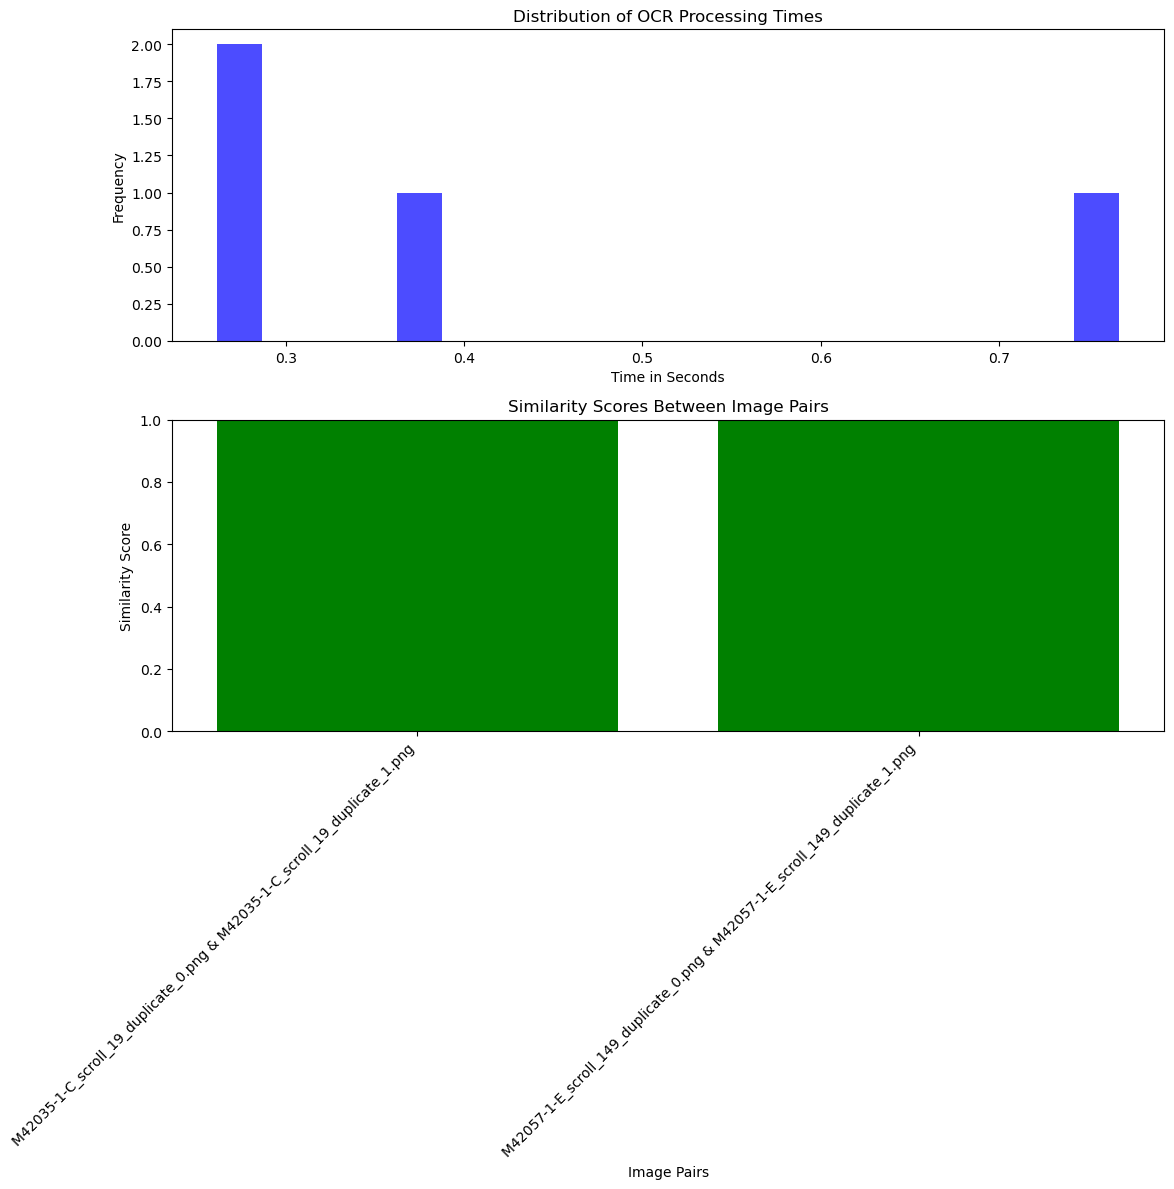

In [35]:
plot_processing_and_similarity(processing_times, similar_images)


# Check of all photos
- now after sainty check works I need to turn on the OCR on all my photos

In [36]:
import os
import shutil

def copy_files_to_directory(source_dir, target_dir):
    for file_name in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file_name)
        if os.path.isfile(file_path):
            shutil.copy(file_path, target_dir)

In [37]:
path_resize_all_photos = os.path.join(path_final_project, 'resize_all_photos')
    
if not os.path.exists(path_resize_all_photos):
    os.makedirs(path_resize_all_photos)
    
# Copy files from Train to resize_all_photos
copy_files_to_directory(path_resize_train, path_resize_all_photos)
# Copy files from Test to resize_all_photos
copy_files_to_directory(path_resize_test, path_resize_all_photos)
print("Files copied successfully.")


Files copied successfully.


# copy for 50 images

In [38]:
import random

def copy_from_all_to_part(source_dir, target_dir, num_files_to_copy):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # List all files in the source directory
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    
    # Randomly pick the specified number of files if there are enough
    if len(files) < num_files_to_copy:
        print("Warning: Requested number of files exceeds the available files.")
        num_files_to_copy = len(files)  # Adjust to the maximum available if requested too many
    
    selected_files = random.sample(files, num_files_to_copy)  # Select files randomly
    
    # Copy the randomly selected files
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(target_dir, file)
        shutil.copy(source_path, destination_path)
        print(f"Copied {file} from {source_dir} to {target_dir}")

In [39]:
path_resize_50_pic = os.path.join(path_final_project, '50_pic_orc')
    
if not os.path.exists(path_resize_all_photos):
    os.makedirs(path_resize_all_photos)
    
# Copy files from Train to resize_all_photos
number_of_files_to_copy = 50  # Set this to however many files you want to copy

copy_from_all_to_part(path_resize_all_photos, path_resize_50_pic, number_of_files_to_copy)

Copied M40588-1-C_scroll_24.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc
Copied M41775-1-E_scroll_37.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc
Copied M42495-1-E_scroll_5.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc
Copied M42176-1-E_scroll_21.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc
Copied M42035-1-C_scroll_92.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc
Copied M44114-3-(2)C_scroll_23.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc
Copied M43174-1-E_scroll_17.png 

In [40]:
similar_images, processing_times = find_similar_images(path_resize_50_pic, model)

# Save results
results_file = os.path.join(path_final_project, 'similar_50_pic.txt')
save_similar_images_to_file(similar_images, results_file)


print(f"Found and saved {len(similar_images)} pairs of similar images.")

path_to_similar_pic50 = os.path.join(path_final_project, 'similar_images_from_50pic')
    
# Copy similar images to a new directory
copy_similar_images(path_resize_50_pic, path_to_similar_pic50, results_file)
       







Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc\M40588-1-C_scroll_24.png: 0. ז -

1 4. לא
- (.:
[ ז) 2
)ז׳
 | Processing Time: 0.34 seconds
Processed M40588-1-C_scroll_24.png: Time taken = 0.3419151306152344s, Text Length = 33
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc\M41138-1-C_scroll_26.png: ז״ ״אל
לוי׳ [י
ז זיז
 | Processing Time: 0.29 seconds
Processed M41138-1-C_scroll_26.png: Time taken = 0.2870943546295166s, Text Length = 21
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc\M41285-1-E_scroll_11.png: ד אכס2 ע
לצצאא לאאצבא [
לל א (לגבלאללק] בא -
3 - זהה גד -
[ללאאאאבא ע האא-
אילצמל. הה
אאר אש
ידה( (ל | Processing Time: 0.52 seconds
Processed M41285-1-E_scroll_11.png: Time taken = 0.5159616470336914s, Text Length = 228
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\50_pic_orc\M41285-1-E_scroll_26.png: - בלא צאצא
ממח 2גי 1
נהל פ4
לאל -
ל 20
ו צ ם ש
- 5572900 ר
8 - א
. איהעלל ללאאא ל
כר4ללד אאש


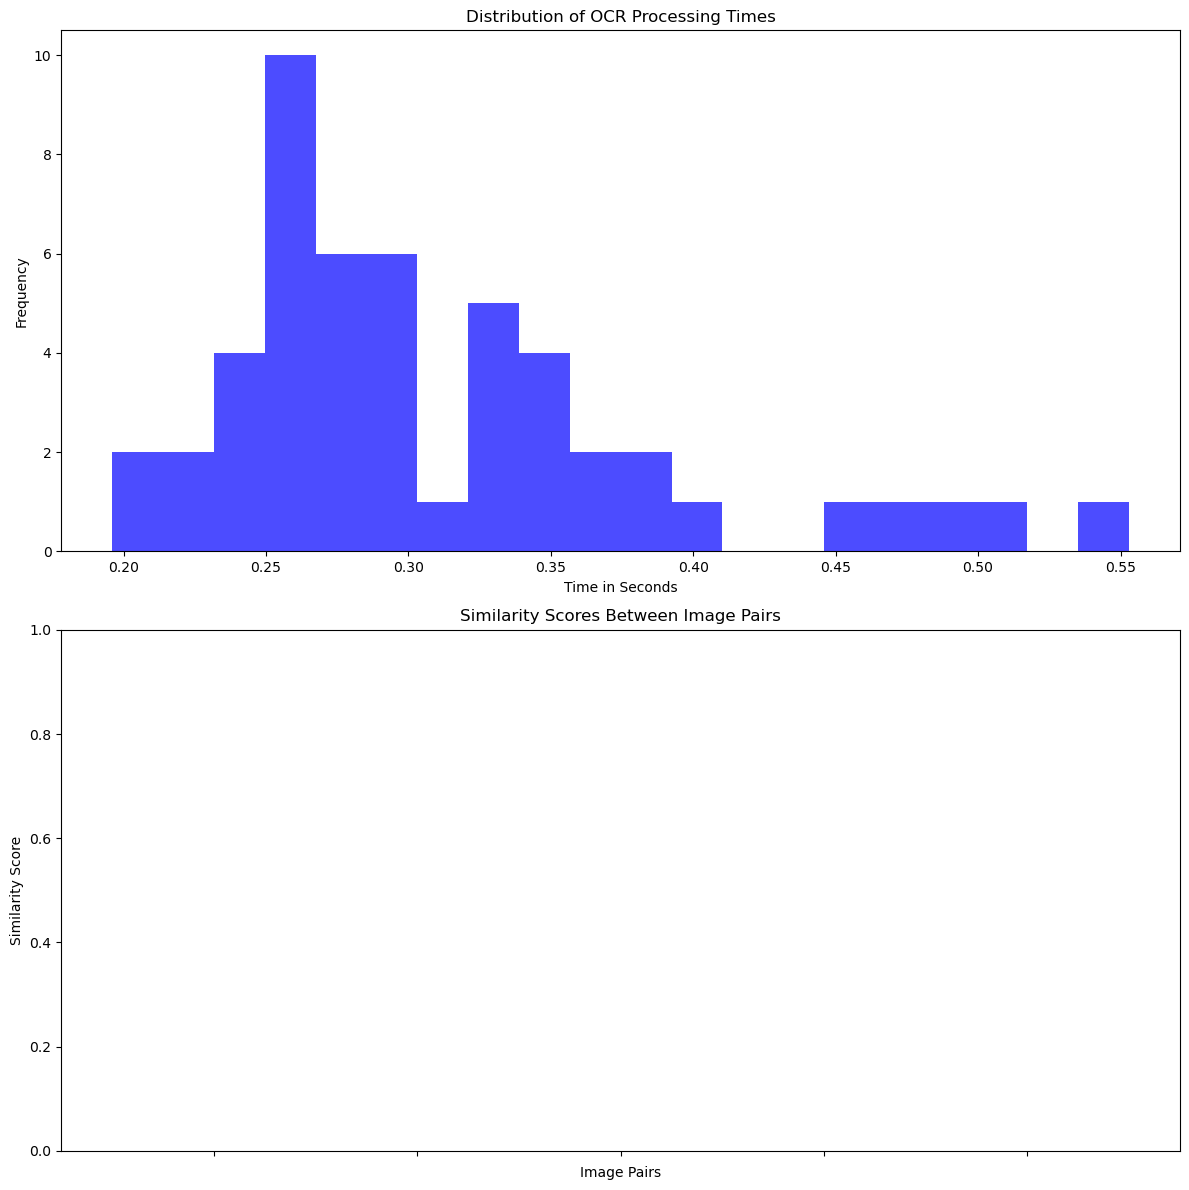

In [41]:
plot_processing_and_similarity(processing_times, similar_images)


# Copy 200 Images and check

In [42]:
path_resize_200_pic = os.path.join(path_final_project, '200_pic_orc')
    
if not os.path.exists(path_resize_all_photos):
    os.makedirs(path_resize_all_photos)
    
# Copy files from Train to resize_all_photos
number_of_files_to_copy = 200  # Set this to however many files you want to copy

copy_from_all_to_part(path_resize_all_photos, path_resize_200_pic, number_of_files_to_copy)

Copied M42150-1-E_scroll_6.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc
Copied M42057-1-E_scroll_46.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc
Copied M43505-1-E_scroll_7.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc
Copied M42558-1-E_scroll_21.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc
Copied M41775-1-E_scroll_42.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc
Copied M40613-1-E_scroll_18.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc
Copied M43174-1-E_scroll_92.pn

In [43]:
similar_images, processing_times = find_similar_images(path_resize_200_pic, model)

# Save results
results_file = os.path.join(path_final_project, 'similar_200_pic.txt')
save_similar_images_to_file(similar_images, results_file)


print(f"Found and saved {len(similar_images)} pairs of similar images.")

path_to_similar_pic200 = os.path.join(path_final_project, 'similar_images_from_200pic')
    
# Copy similar images to a new directory
copy_similar_images(path_resize_200_pic, path_to_similar_pic200, results_file)
       


Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc\M40581-1-C_scroll_12.png: י. צי
- 42- ז
יר דיש.
 | Processing Time: 0.26 seconds
Processed M40581-1-C_scroll_12.png: Time taken = 0.2575681209564209s, Text Length = 22
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc\M40586-1-C_scroll_31.png: 4 22223
ט -.
ב:
 | Processing Time: 0.31 seconds
Processed M40586-1-C_scroll_31.png: Time taken = 0.308246374130249s, Text Length = 16
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc\M40586-1-C_scroll_4.png: ודעה
1 ז -
 | Processing Time: 0.28 seconds
Processed M40586-1-C_scroll_4.png: Time taken = 0.2848219871520996s, Text Length = 11
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\200_pic_orc\M40586-1-C_scroll_7.png: ל22 2
-[ז-. -
6 74
 | Processing Time: 0.27 seconds
Processed M40586-1-C_scroll_7.png: Time taken = 0.2736663818359375s, Text Length = 19
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\

C:\Users\ilaiga.Owner\AppData\Local\Temp\ipykernel_15676\3826671765.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha="right")


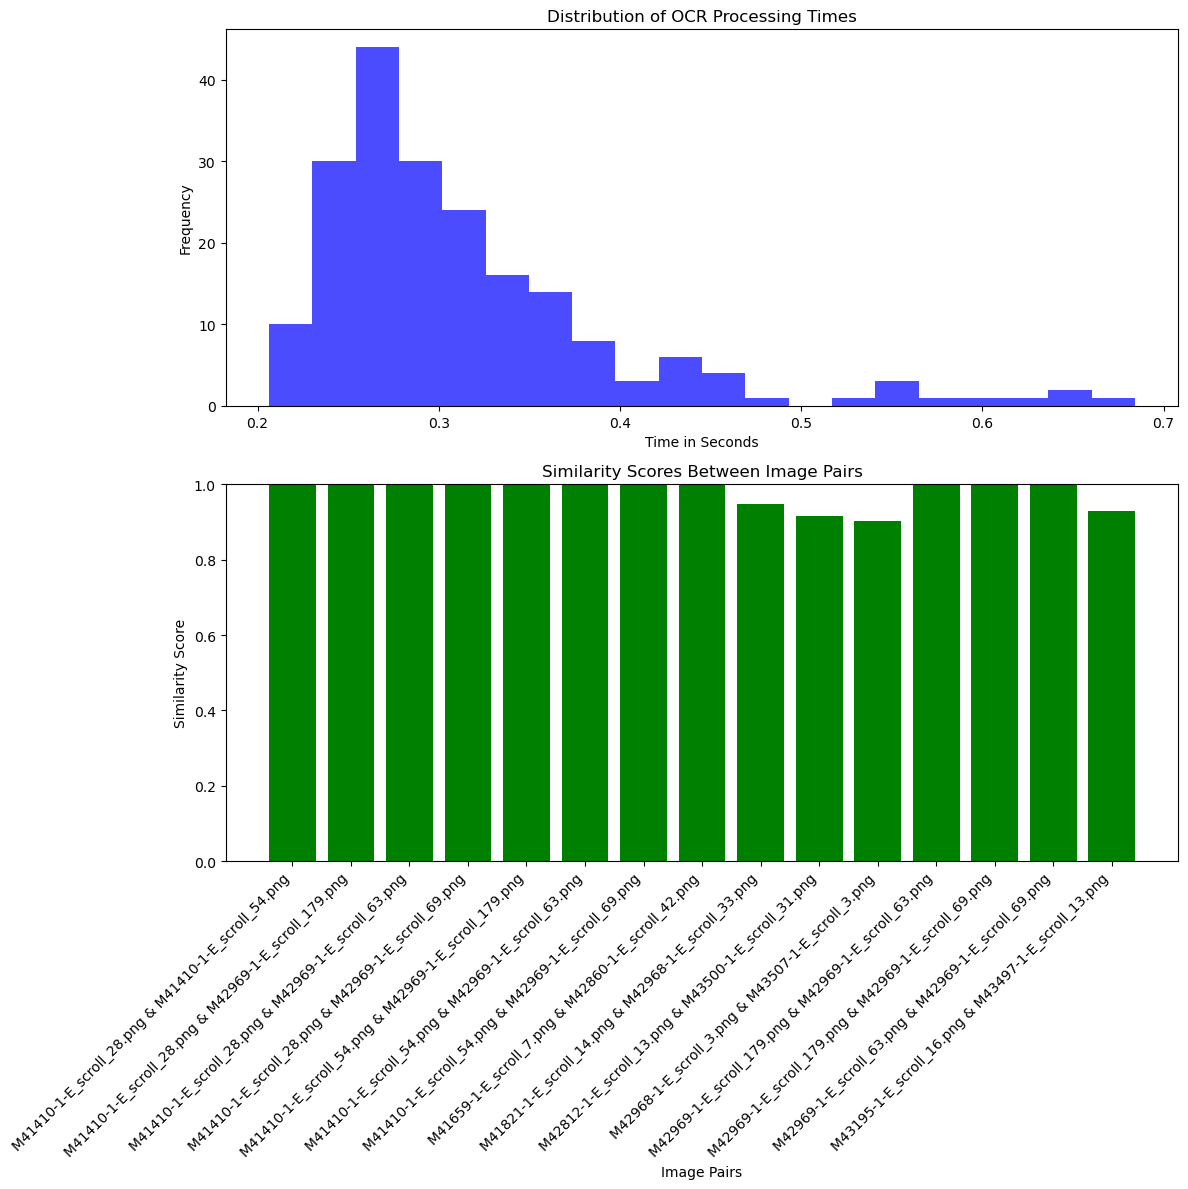

In [44]:
plot_processing_and_similarity(processing_times, similar_images)

# 500 pictures
- That my last check beacuse try on all picture takes lot of time and my computer can not do it in good time processing

In [45]:
path_resize_500_pic = os.path.join(path_final_project, '500_pic_orc')
    
if not os.path.exists(path_resize_500_pic):
    os.makedirs(path_resize_500_pic)
    
# Copy files from Train to resize_all_photos
number_of_files_to_copy = 500  

copy_from_all_to_part(path_resize_all_photos, path_resize_500_pic, number_of_files_to_copy)

Copied M42057-1-E_scroll_21.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc
Copied M41516-1-E_scroll_9.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc
Copied M40613-1-E_scroll_13.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc
Copied M42470-1-E_scroll_12.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc
Copied M42149-1-E_scroll_5.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc
Copied M40588-1-C_scroll_20.png from C:\Users\ilaiga.Owner\Downloads\final_project\resize_all_photos to C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc
Copied M42860-1-E_scroll_10.pn

In [46]:

similar_images, processing_times = find_similar_images(path_resize_500_pic, model)

# Save results
results_file = os.path.join(path_final_project, 'similar_500_images.txt')
save_similar_images_to_file(similar_images, results_file)


print(f"Found and saved {len(similar_images)} pairs of similar images.")

path_to_similar_500pic = os.path.join(path_final_project, 'similar_images_from_500pic')
    
# Copy similar images to a new directory
copy_similar_images(path_resize_all_photos, path_to_similar_500pic, results_file)
       

Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc\M40581-1-C_scroll_0.png: ל לל[ ל 63
. (([לל לל אאאללזזזז א
ו גושו (ל[אזלאלצא2א[[ז
ל. צ אזל. לל דז׳ גי. ו לאל
[[ לגאול ((לג לל | Processing Time: 0.48 seconds
Processed M40581-1-C_scroll_0.png: Time taken = 0.47868943214416504s, Text Length = 234
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc\M40581-1-C_scroll_14.png: ) איל
״צא יל --׳
 | Processing Time: 0.27 seconds
Processed M40581-1-C_scroll_14.png: Time taken = 0.26871633529663086s, Text Length = 17
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc\M40581-1-C_scroll_17.png: לללג:גג60-
.) ( יי - - ז - ו
צל(ילל 2-7 [א לל[: וז

׳ -ד-׳ אל לל[: לא ט6-
 | Processing Time: 0.32 seconds
Processed M40581-1-C_scroll_17.png: Time taken = 0.3208041191101074s, Text Length = 74
Extracted from C:\Users\ilaiga.Owner\Downloads\final_project\500_pic_orc\M40581-1-C_scroll_20.png: 46 [ללל]
צא. א 11 - 72
[[ל ז [ לן
ז זג 467 4 4
3 צלל

# All Images
- now if you want to compare all images you should did it like that
- that cells will run more then 24 hours so I can't run it

In [47]:

similar_images, processing_times = find_similar_images(path_resize_all_photos, model)

# Save results
results_file = os.path.join(path_final_project, 'similar_all_images.txt')
save_similar_images_to_file(similar_images, results_file)


print(f"Found and saved {len(similar_images)} pairs of similar images.")

path_to_similar_allpic = os.path.join(path_final_project, 'similar_images_from_allpic')
    
# Copy similar images to a new directory
copy_similar_images(path_resize_all_photos, path_to_similar_allpic, results_file)
   


'\nsimilar_images, processing_times = find_similar_images(path_resize_all_photos, model)\n\n# Save results\nresults_file = os.path.join(path_final_project, \'similar_all_images.txt\')\nsave_similar_images_to_file(similar_images, results_file)\n\n\nprint(f"Found and saved {len(similar_images)} pairs of similar images.")\n\npath_to_similar_allpic = os.path.join(path_final_project, \'similar_images_from_allpic\')\n    \n# Copy similar images to a new directory\ncopy_similar_images(path_resize_all_photos, path_to_similar_allpic, results_file)\n'

In [48]:

plot_processing_and_similarity(processing_times, similar_images)


'\nplot_processing_and_similarity(processing_times, similar_images)\n'